# Super Resolution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install torchmetrics
!pip install diffusers[training]

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 868 kB 3.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.2 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 401 kB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 39.0 MB/s eta 0:00:01
     |████████████████████████████████| 542 kB 54.1 MB/s eta 0:00:01
     |████████████████████████████████| 251 kB 56.9 MB/s eta 0:00:01
     |████████████████████████████████| 316 kB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.1 MB 56.4 MB

In [ ]:
!sudo pip uninstall -y transformer-engine

In [ ]:
!pip install opencv-python==4.8.0.74

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import copy
import cv2
import os
import json
import time

from PIL import Image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from model import UNet
from dsr import DSRDataset
from pathlib import Path

from srd import SuperResolutionDataset

train_dataset = SuperResolutionDataset(data_path='flowers/train', resolution=128)
val_dataset = SuperResolutionDataset(data_path='flowers/valid', resolution=128)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True
)

In [10]:
root = Path('./dsr/')

with open(root / 'train_valid_test_split.json', 'r') as f:
    split = json.load(f)
    
train_dataset = DSRDataset(root, split['train'], resolution=256, real_lr=False)
val_dataset = DSRDataset(root, split['test'], resolution=256, real_lr=False)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    prefetch_factor=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    prefetch_factor=4
)

Loaded 5175 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height None
Loaded 2532 pairs for scenes ['0175', '0169', '0154', '0030', '0180', '0228', '0214', '0229', '0151', '0055', '0071', '0225', '0153', '0102', '0156', '004

Time taken to get next batch of images: 1.0481791496276855 seconds
(16, 3, 256, 256)
(16, 3, 256, 256)
mean: 0.01922082
variance: 0.1545043
min: -1.0
max: 1.0


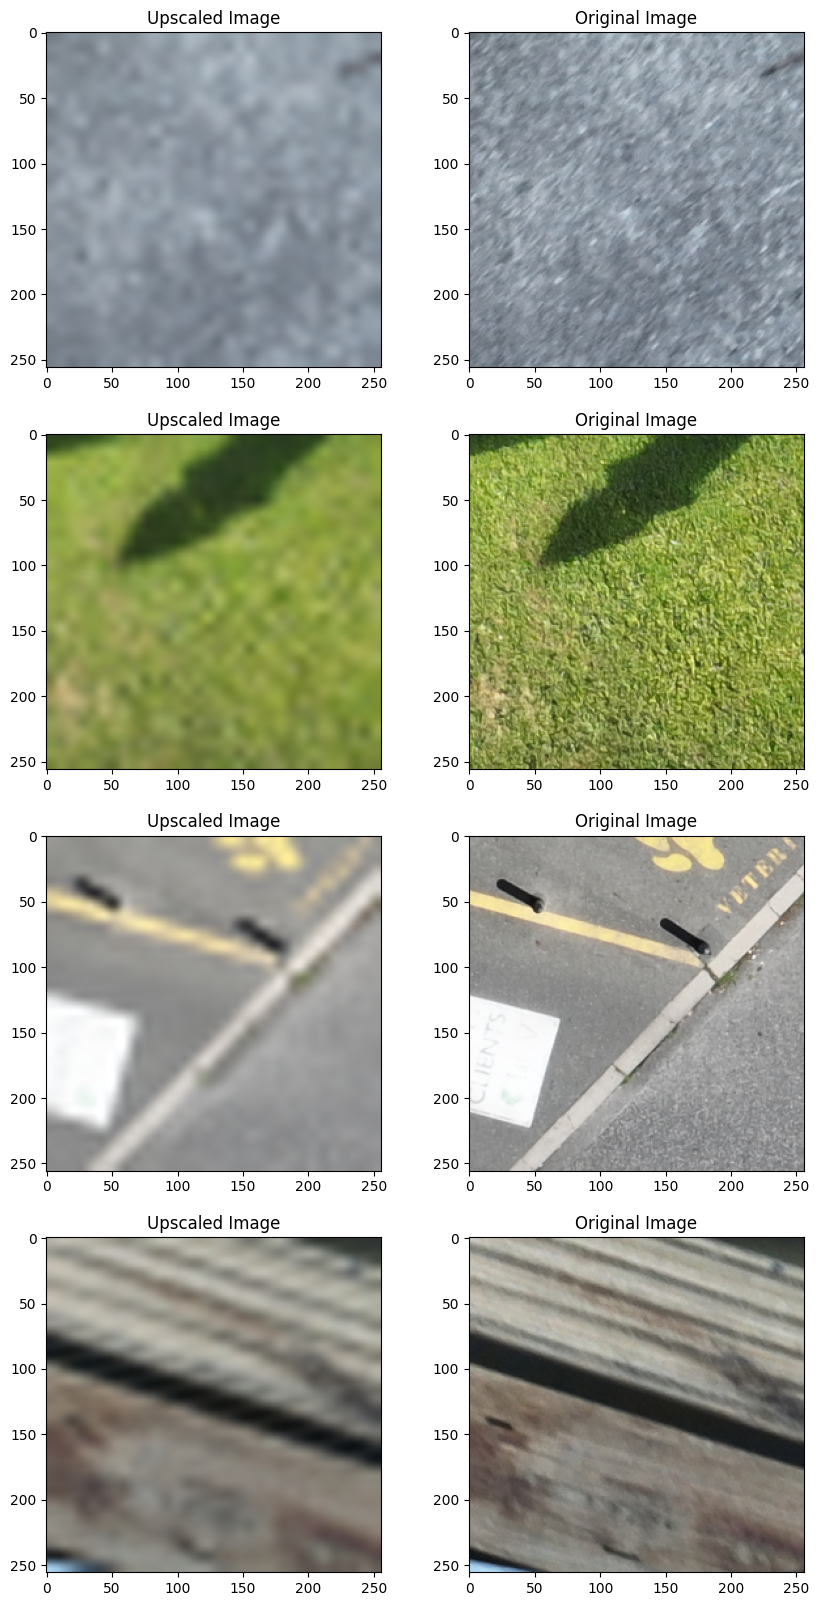

In [9]:
start_time = time.time()

images = next(iter(train_loader))
lowres_images = images[0].numpy()
highres_images = images[1].numpy()

elapsed_time = time.time() - start_time
print(f"Time taken to get next batch of images: {elapsed_time} seconds")

print(lowres_images.shape)
print(highres_images.shape)

print('mean:', highres_images.mean())
print('variance:', highres_images.var())
print('min:', highres_images.min())
print('max:', highres_images.max())

fig, axes = plt.subplots(figsize=(10, 20), nrows=4, ncols=2)
for i in range(4):
    ax = axes[i]

    lowres_image = (lowres_images[i] + 1) / 2
    highres_image = (highres_images[i] + 1) / 2

    ax[0].imshow(lowres_image.transpose(1, 2, 0))
    ax[0].set_title('Upscaled Image')

    ax[1].imshow(highres_image.transpose(1, 2, 0))
    ax[1].set_title('Original Image')

plt.show()

## U-Net

![Example Image](unet.png)

In [11]:
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet2DModel(
        sample_size=256,  # the target image resolution
        in_channels=6,  # the number of input channels, 3 for RGB images
        out_channels=3,  # the number of output channels
        layers_per_block=3,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 256, 512, 1024, 1024),  # the number of output channels for each UNet block
        norm_num_groups=1,
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D"
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D"
        ),
    ).to(device)

criterion = nn.MSELoss()
epochs = 2
T = 2000
diffusion_scheduler = DDIMScheduler(num_train_timesteps=T, beta_schedule='squaredcos_cap_v2')
tensorboard_path="./runs/diffusion-525M-dsr-256R-cosine-1e-4"

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_loader) * epochs),
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params, device)

Number of parameters: 525754371 cuda


In [12]:
from train import train

train(model, diffusion_scheduler, train_loader, val_loader, epochs, device, optimizer, lr_scheduler, criterion, tensorboard_path, num_accumulation_steps=4)

Starting training for 2 epochs
Accumulation steps: 4
Logging to: ./runs/diffusion-525M-dsr-256R-cosine-1e-4


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 Iteration 0 Loss 1.0393638610839844
Epoch 0 Iteration 50 Loss 0.9939796328544617


  0%|          | 0/2 [01:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'dsr_sr.pth')

In [ ]:
model.load_state_dict(torch.load('dsr_sr.pth'))

In [ ]:
X, y = next(iter(val_loader))

num_samples = X.shape[0]  # batch size
X = X.to(device)
y = y.to(device)

samples = diffusion_scheduler.generate(unet, X, batch_size=num_samples, num_inference_steps=100)
samples = samples[-1]

X = (X + 1) / 2
y = (y + 1) / 2
samples = (samples + 1) / 2

fig, ax = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i in range(num_samples):
    ax[i, 0].imshow(X[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 0].set_title("Condition image")

    ax[i, 1].imshow(samples[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 1].set_title("Sample image")

    ax[i, 2].imshow(y[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 2].set_title("Target image")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

def update(i):
    if i < len(samples):
        image = np.clip(samples[i][0].detach().numpy(), 0, 1)
    else:
        last_frame_index = len(samples) - 1
        image = np.clip(samples[last_frame_index][0].detach().numpy(), 0, 1)
        
    image = np.concatenate((X[0].cpu().numpy(), image), axis=2)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    
ani = animation.FuncAnimation(fig, update, frames=len(samples) + 60, interval=60)
HTML(ani.to_jshtml())

In [ ]:
ani.save('denoising_sr.gif', writer='imagemagick', fps=30)